In [10]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy.io import wavfile

Butterworth filter

In [11]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

Butterworth filter bode plot

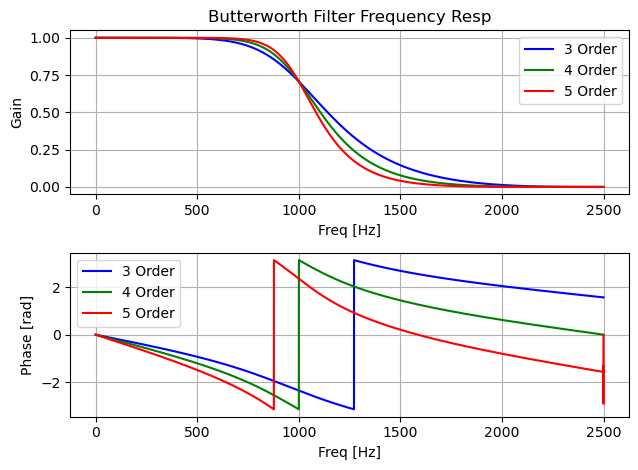

In [12]:
# amp, phase 전부
fs = 5000
cutoff = 1000

colors = ['b', 'g', 'r']

for i in range(3):
    b, a = butter_lowpass(cutoff, fs, order=(i + 3))
    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(.5 * fs * w / np.pi, np.abs(h), colors[i], label=f"{i + 3} Order")
    plt.title("Butterworth Filter Frequency Resp")
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Gain")
    plt.grid()
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(.5 * fs * w / np.pi, np.angle(h), colors[i], label=f"{i + 3} Order")
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Phase [rad]")
    plt.grid()
    plt.legend()
    
plt.tight_layout()
plt.show()


wav 파일 읽기 및 필터 적용

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fs, data = wavfile.read('../media/sample.wav')

In [14]:
for i in range(5):
    b, a = butter_lowpass(1000, fs, i + 2)
    filtered_data = lfilter(b, a, data) 
    wavfile.write(f'../media/output_butter_{i + 2}.wav', fs, filtered_data.astype(np.int16))

적용된 필터 간 비교

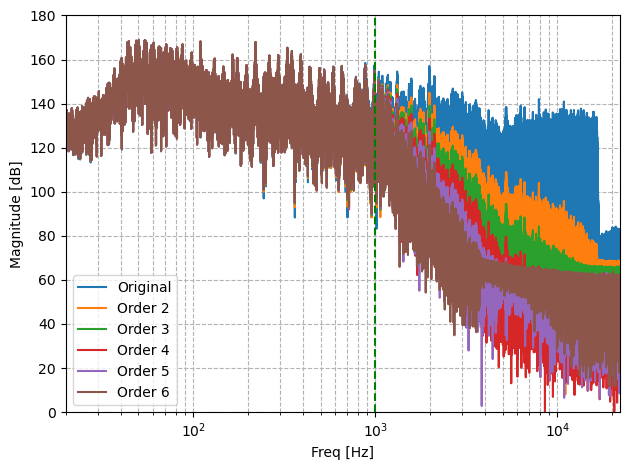

In [15]:
from scipy.fftpack import fft

cutoff = 1000

def plot_spectrum(data, fs, label):
    N = len(data)
    yf = fft(data)
    xf = np.linspace(0., 1./(2./fs), N//2)
    dB = 20 * np.log10(np.abs(yf[0:N//2]))
    plt.plot(xf, dB, label=label)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fs, original_data = wavfile.read('../media/sample.wav')
    plot_spectrum(original_data, fs, "Original")
    
    for i in range(5):
        fs, filtered_data = wavfile.read(f"../media/output_butter_{i + 2}.wav")
        plot_spectrum(filtered_data, fs, f"Order {i + 2}")

    plt.xscale('log')
    plt.xlabel('Freq [Hz]')
    plt.ylabel('Magnitude [dB]')
    
    plt.axvline(cutoff, color='g', linestyle='--')
    
    plt.xlim(20, fs/2)
    plt.ylim(0, 180)
    plt.legend()
    plt.grid(True, which="both", ls='--', c='0.7')
    plt.tight_layout()
    plt.show()

type 1, 2 chebyshev 필터 plot

In [16]:
from scipy.signal import cheby1, cheby2

def cheby(cutoff, fs, order=5, ripple=1):
    nyq = .5 * fs
    normal_cutoff = cutoff / nyq
    
    b1, a1 = cheby1(order, ripple, normal_cutoff, btype='low', analog=False)
    b2, a2 = cheby2(order, ripple, normal_cutoff, btype='low', analog=False)
    
    return {
        'type I': (b1, a1),
        'type II': (b2, a2)
        }

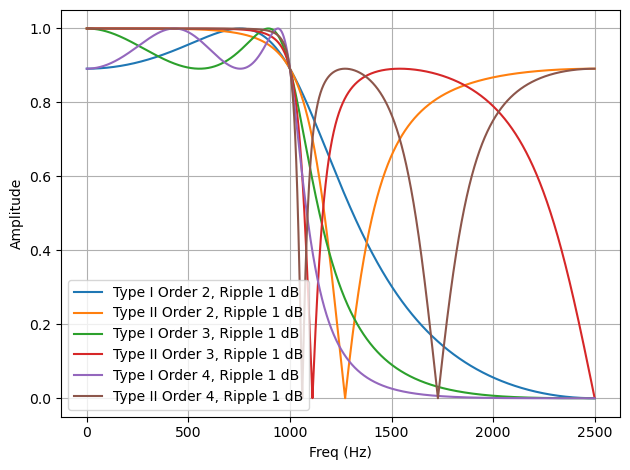

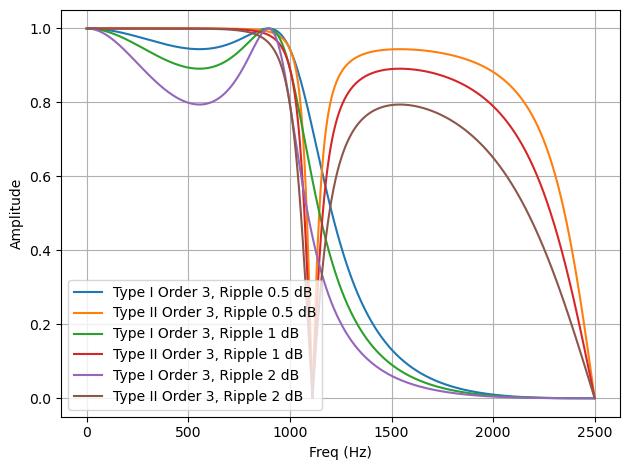

In [17]:
cutoff = 1000
fs = 5000
orders = [2, 3, 4]
ripples = [.5, 1, 2]

def plot_cheby(cutoff, fs):
    for order in orders:
        filters = cheby(cutoff, fs, order=order, ripple=1)
        b1, a1 = filters['type I']
        w, h = freqz(b1, a1, worN=8000)
        plt.plot(.5 * fs * w / np.pi, abs(h), label=f"Type I Order {order}, Ripple 1 dB")
        
        b2, a2 = filters['type II']
        w, h = freqz(b2, a2, worN=8000)
        plt.plot(.5 * fs * w / np.pi, abs(h), label=f"Type II Order {order}, Ripple 1 dB")

    plt.xlabel("Freq (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    for ripple in ripples:
        filters = cheby(cutoff, fs, order=3, ripple=ripple)
        b1, a1 = filters['type I']
        w, h = freqz(b1, a1, worN=8000)
        plt.plot(.5 * fs * w / np.pi, abs(h), label=f"Type I Order 3, Ripple {ripple} dB")

        b2, a2 = filters['type II']
        w, h = freqz(b2, a2, worN=8000)
        plt.plot(.5 * fs * w / np.pi, abs(h), label=f"Type II Order 3, Ripple {ripple} dB")

    plt.xlabel("Freq (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()            
    
plot_cheby(cutoff=cutoff, fs=fs)

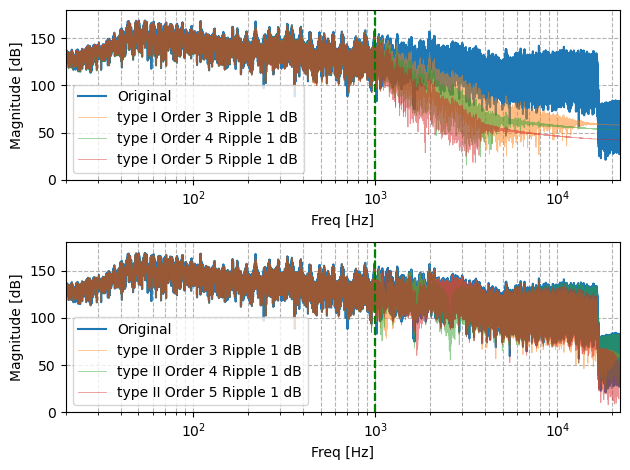

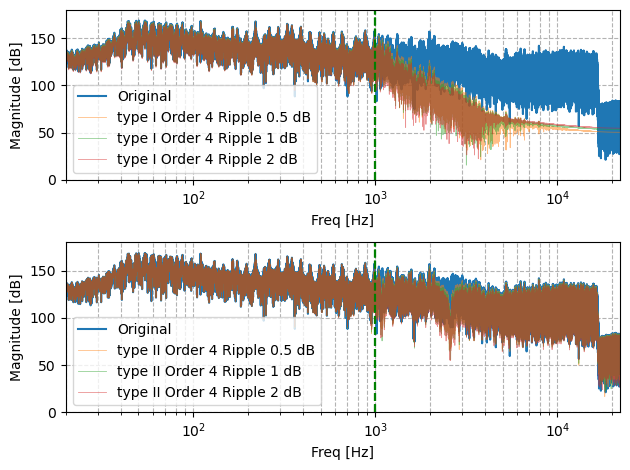

In [18]:
cutoff = 1000

def plot_original(data, fs):
    N = len(data)
    yf = fft(data)
    xf = np.linspace(0., 1./(2./fs), N//2)
    dB = 20 * np.log10(np.abs(yf[0:N//2]))
    plt.plot(xf, dB, label="Original")

def select_type(data, fs, type, order = 4, ripple = 1):
    filters = cheby(cutoff, fs, order=order, ripple=ripple)
    
    b, a = filters[f'type {"I" if type == 1 else "II"}']
    cheby_data = lfilter(b, a, data) 
    wavfile.write(f'../media/output_cheby{type}_{order}.wav', fs, cheby_data.astype(np.int16))

    N = len(cheby_data)
    yf = fft(cheby_data)
    xf = np.linspace(0., 1./(2./fs), N//2)
    dB = 20 * np.log10(np.abs(yf[0:N//2]))
    plt.plot(
        xf,
        dB,
        label=f'type {"I" if type == 1 else "II"} Order {order} Ripple {ripple} dB',
        alpha=.5,
        linewidth=.6
        )
    plt.legend()
    plt.xscale('log')
    plt.xlabel('Freq [Hz]')
    plt.ylabel('Magnitude [dB]')
    
    plt.axvline(cutoff, color='g', linestyle='--')
    
    plt.xlim(20, fs/2)
    plt.ylim(0, 180)
    plt.legend()
    plt.grid(True, which="both", ls='--', c='0.7')

        
def select_order(data, fs, orders = [3, 4, 5]):
    plt.subplot(2, 1, 1)
    plot_original(data, fs)

    plt.subplot(2, 1, 2)
    plot_original(data, fs)
    for order in orders:
        plt.subplot(2, 1, 1)
        select_type(data, fs, 1, order=order)

        plt.subplot(2, 1, 2)
        select_type(data, fs, 2, order=order)

    plt.tight_layout()
    plt.show()
        
def select_ripple(data, fs, ripples = [.5, 1, 2]):
    plt.subplot(2, 1, 1)
    plot_original(data, fs)

    plt.subplot(2, 1, 2)
    plot_original(data, fs)
    for ripple in ripples:
        plt.subplot(2, 1, 1)
        select_type(data, fs, 1, ripple=ripple)

        plt.subplot(2, 1, 2)
        select_type(data, fs, 2, ripple=ripple)
        
    plt.tight_layout()
    plt.show()
        
def filtered(data, fs):
    select_order(data, fs)
    select_ripple(data, fs)
    
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fs, data = wavfile.read('../media/sample.wav')
    
    filtered(data, fs)
